this `hammer` module is install from rust binding with pyO3

check `rust` folder for more details

# Create mock data for Dark Matter Halo model

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from hammer import Model 
from os.path import join, abspath, pardir
import sys
import vaex

In [2]:
root_dir = abspath(join(pardir))
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/5_mcmc',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import concat, style

style()

In [5]:
root_data_dir = join(root_dir, 'Data')
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [6]:
baryon_dir = join(root_data_dir, "Baryon")
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


## Math

from Poisson eq.
\begin{aligned}
  \nabla^2\Phi(z, r, \phi) = \frac{\partial^2 \Phi}{\partial z^2}+\frac{1}{r^2}\frac{\partial \Phi}{\partial \phi^2} + \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) = 4\pi G\rho
\end{aligned}

Assume axisymmetric potential, and can be decoupled
\begin{aligned}
  \Phi(z, r, \phi) =  \Phi(z, r) =  \Phi_z(z) + \Phi_r(r)
\end{aligned}

Therefore
\begin{aligned}
  \nabla^2\Phi(z, r, \phi)  = \frac{\partial^2 \Phi_z}{\partial z^2}+ \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) = 4\pi G\rho
\end{aligned}

where (Buch et. al. [2019](https://iopscience.iop.org/article/10.1088/1475-7516/2019/04/026))
\begin{aligned}
  \mathcal{R} &= \frac{1}{(4\pi G)} \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) \\
    &= (3.4\pm 0.6)\times10^{-3} M_\odot /\text{pc}^3
\end{aligned}

and $\rho$ is divided into three parts
* Baryon, $\rho_i$
* Thin Dark Disk, $\rho_\text{DD}$
* Constant Local Halo Dark Matter $\rho_\text{DM}$


Using Bahcall Model for Baryon, for each components
\begin{aligned}
  \rho_i = \rho_{i,0}\exp{\left(-\frac{\Phi(z)}{\sigma_{z,i}}\right)}
\end{aligned}
And total baryons
\begin{aligned}
  \rho_b = \sum_i^N\rho_i
\end{aligned}

For thin DD
\begin{aligned}
  \rho_\text{DD}(z) = \frac{\Sigma_\text{DD}}{4h_\text{DD}}\text{sech}^2\left(\frac{z}{2h_\text{DD}}\right)
\end{aligned}

So,
\begin{aligned}
  \frac{\partial^2 \Phi_z}{\partial z^2} &= 4\pi G\rho_\text{eff} \\
  \frac{1}{4\pi G}\frac{\partial^2 \Phi_z}{\partial z^2} &= \sum_i^N\left[\rho_{i,0}\exp{\left(-\frac{\Phi(z)}{\sigma_{z,i}}\right)}\right] + \frac{\Sigma_\text{DD}}{4h_\text{DD}}\text{sech}^2\left(\frac{z}{2h_\text{DD}}\right) + \rho_\text{DM} - \mathcal{R}
\end{aligned}

All of this math has been baked into `hammer` module. Check out the `rust` folder for more details.

Example

In [7]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101

rhob = np.array(df_baryon["rho"].to_numpy())  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
rhoDM = 0.016
# sigmaDD = 7
# hDD = 30
log_nu0 = 0
zsun = 30
R = 3.4E-3
w0 = -7
sigmaw1 = 5
sigmaw2 = 10
log_sigmaw = np.log(sigmaw1)
q_sigmaw = sigmaw1/sigmaw2
a1 = 1
a2 = 0.1
log_a = np.log(a1)
q_a = a2/a1

theta = concat(sigmaz, rhob, rhoDM, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)

# integration limits
z_start = 0
z_end = 400
theta.shape

(33,)

integrate using `mcmc.dm`

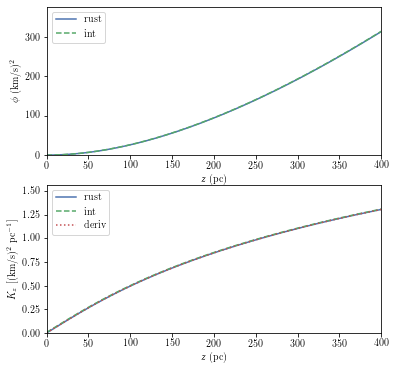

In [8]:
dz = 1
z, phi, Kz = Model.DM.solve_potential(theta, z_start, z_end, dz)
u = np.array([phi, Kz])
dphi, dKz = Model.DM.velocity(z, u, theta)
phi_int = np.cumsum(dphi)*dz
Kz_int = np.cumsum(dKz)*dz
Kz_deriv = np.gradient(phi, z)
# subplot
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(z, phi, label=r"rust")
ax[0].plot(z, phi_int, label=r"int", ls="--")
ax[0].set_xlabel(r"$z$ (pc)")
ax[0].set_ylabel(r"$\phi$ (km/s)$^2$")
ax[0].set_xlim(0, z[-1])
ax[0].set_ylim(0, phi[-1]*1.2)
ax[0].legend()
ax[1].plot(z, Kz, label=r"rust")
ax[1].plot(z, Kz_int, label=r"int", ls="--")
ax[1].plot(z, Kz_deriv, label=r"deriv", ls=":")
ax[1].set_xlabel(r"$z$ (pc)")
ax[1].set_ylabel(r"$K_z$ [(km/s)$^2$ pc$^{-1}$]")
ax[1].set_xlim(0, z[-1])
ax[1].set_ylim(0, Kz[-1]*1.2)
ax[1].legend()
# plt.tight_layout()
plt.show()

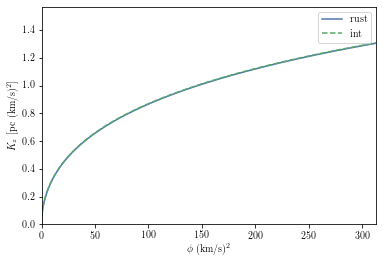

In [9]:
plt.plot(u[0], u[1], label=r"rust")
plt.plot(phi_int, Kz_int, label=r"int", ls="--")
plt.xlabel(r"$\phi$ (km/s)$^2$")
plt.ylabel(r"$K_z$ [pc (km/s)$^2$]")
plt.xlim(0, u[0][-1])
plt.ylim(0, u[1][-1]*1.2)
plt.legend()
plt.show()

Check the difference for different z interval

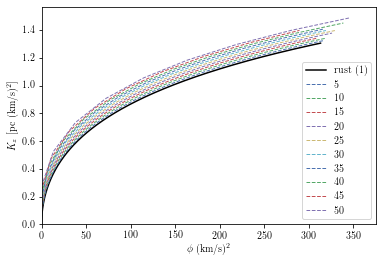

In [10]:
z, phi, Kz = Model.DM.solve_potential(theta, z_start, z_end, 1)
plt.plot(phi, Kz, label=r"rust (1)", c='k')
for dz in range(5, 51, 5):
    z, phi, Kz = Model.DM.solve_potential(theta, z_start, z_end, dz)
    u = np.array([phi, Kz])
    dphi, dKz = Model.DM.velocity(z, u, theta)
    phi_int = np.cumsum(dphi)*dz
    Kz_int = np.cumsum(dKz)*dz
    plt.plot(phi_int, Kz_int, label=dz, ls="--", lw=1)
plt.xlabel(r"$\phi$ (km/s)$^2$")
plt.ylabel(r"$K_z$ [pc (km/s)$^2$]")
plt.xlim(0, u[0][-1]*1.2)
plt.ylim(0, u[1][-1]*1.2)
plt.legend()
plt.show()

the interval `z = 1` is the most accurate

# Potential

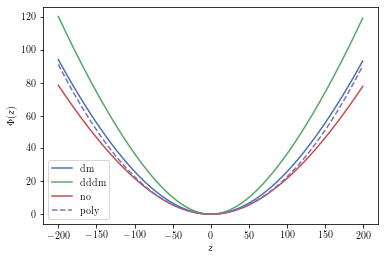

In [11]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101

sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
rhob = np.array(df_baryon["rho"].to_numpy())  # Msun/pc^3
rhoDM = 0.016
sigmaDD = 7
hDD = 30
log_nu0 = 0
zsun = 0
R = 3.4E-3
w0 = -7
sigmaw1 = 5
sigmaw2 = 10
log_sigmaw = np.log(sigmaw1)
q_sigmaw = sigmaw1/sigmaw2
a1 = 5
a2 = 1
log_a = np.log(a1)
q_a = a2/a1

theta_dm = concat(sigmaz, rhob, rhoDM, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)
theta_dddm = concat(sigmaz, rhob, rhoDM, sigmaDD, hDD, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)
theta_no = concat(sigmaz, rhob, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)

z_start = -200
z_end = 200
dz = 1.

z = np.arange(z_start, z_end, dz)

phi_dm = Model.DM.potential(z, theta_dm, dz)
phi_dddm = Model.DDDM.potential(z, theta_dddm, dz)
phi_no = Model.NO.potential(z, theta_no, dz)
mask = np.abs(z) < 50
# p = np.polyfit(z[mask], phi_dm[mask], 2)
# p = np.polyfit(z[mask], phi_dddm[mask], 2)
p = np.polyfit(z[mask], phi_no[mask], 2)

plt.figure(figsize=(6, 4))
plt.plot(z, phi_dm, label="dm")
plt.plot(z, phi_dddm, label="dddm")
plt.plot(z, phi_no, label="no")
plt.plot(z, np.polyval(p, z), label="poly", ls="--")
plt.xlabel(r'$z$')
plt.ylabel(r'$\Phi(z)$')
plt.legend()
plt.show()


In [12]:
p

array([2.27959081e-03, 2.00107832e-18, 7.45332936e-03])

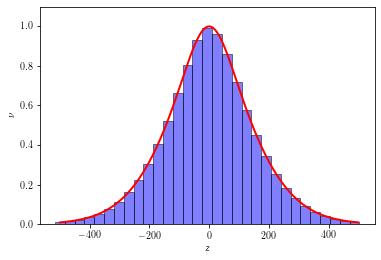

In [13]:
z = np.linspace(-500, 500, 305)
dz = z[10] - z[0]
fz = Model.DM.fz(z[::10], theta_dm, dz)
fz_smooth = Model.DM.fz(z, theta_dm, dz/10)
plt.figure(figsize=(6, 4))
plt.bar(z[::10], fz, width=dz, color='b', alpha=0.5, ec="k")
plt.plot(z, fz_smooth, color='r', lw=2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\nu$')
plt.ylim(0, 1.1)
plt.show()

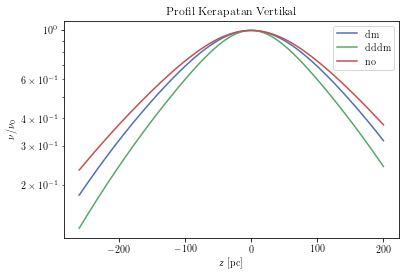

In [14]:
z = np.linspace(-260, 200, 1000)
dz = z[1] - z[0]
fz_dm = Model.DM.fz(z, theta_dm, dz)
fz_dddm = Model.DDDM.fz(z, theta_dddm, dz)
fz_no = Model.NO.fz(z, theta_no, dz)
plt.figure(figsize=(6, 4))
plt.plot(z, fz_dm, label="dm")
plt.plot(z, fz_dddm, label="dddm")
plt.plot(z, fz_no, label="no")
plt.xlabel(r'$z$ [pc]')
plt.ylabel(r'$\nu/\nu_0$')
# plt.ylim(0, 1.1)
plt.title("Profil Kerapatan Vertikal")
plt.yscale("log")
plt.legend()
plt.savefig(join("img", "nuz.pdf"), dpi=70)
plt.show()

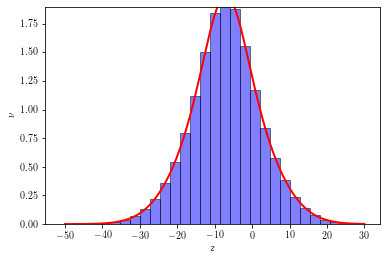

In [15]:
w = np.linspace(-50, 30, 300)
dw = w[10] - w[0]
fw = Model.DM.fw(w[::10], theta_dm)
fw_smooth = Model.DM.fw(w, theta_dm)
plt.figure(figsize=(6, 4))
plt.bar(w[::10], fw, width=dw, color='b', alpha=0.5, ec="k")
plt.plot(w, fw_smooth, color='r', lw=2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\nu$')
plt.ylim(0, 1.9)
plt.show()

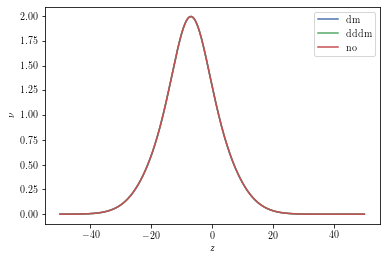

In [16]:
w = np.linspace(-50, 50, 1000)
fw_dm = Model.DM.fw(w, theta_dm)
fw_dddm = Model.DDDM.fw(w, theta_dddm)
fw_no = Model.NO.fw(w, theta_no)
plt.figure(figsize=(6, 4))
plt.plot(w, fw_dm, label="dm")
plt.plot(w, fw_dddm, label="dddm")
plt.plot(w, fw_no, label="no")
plt.xlabel(r'$z$')
plt.ylabel(r'$\nu$')
plt.legend()
plt.show()

In [17]:
# theta_0 = concat(sigmaz, rhob, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a, 0)
# theta_3 = concat(sigmaz, rhob, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a, 3)
# # theta_3 = concat(sigmaz, rhob, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a, 4)

# w = np.linspace(-50, 50, 500)
# fw_0 = Model.NO.fw(w, theta_0)
# fw_3 = Model.NO.fw(w, theta_3)
# # fw_no = Model.NO.fw(w, theta_3)
# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(w, fw_0, c="C0", label="tanpa")
# ax.plot(w, fw_3, c="C1", label="dengan")
# ax.set_xlabel(r'$z$')
# ax.set_ylabel(r'$\nu$')
# axins = ax.inset_axes([0.7, 0.4, 0.27, 0.57])
# axins.plot(w, fw_0, c="C0")
# axins.plot(w, fw_3, c="C1")
# # subregion of the original image
# x1, x2, y1, y2 = 0, 10, 0, 0.5
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# # axins.set_xticklabels([])
# axins.set_yticklabels([])
# ax.legend(loc="upper left")
# ax.indicate_inset_zoom(axins, edgecolor="black")
# # plt.yscale("log")
# ax.set_ylim(0)
# ax.set_xlim(-50, 50)
# ax.set_xlabel(r'$w$ [km/s]')
# ax.set_ylabel(r'$f_0(w)$')
# ax.set_title(r"Distribusi Kecepatan di Bidang")
# fig.savefig(join("img", "f0.pdf"), dpi=70)
# plt.show()

In [17]:
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
rhob = np.array(df_baryon["rho"].to_numpy())  # Msun/pc^3
rhoDM = 0.05
sigmaDD = 7
hDD = 30
log_nu0 = 0
zsun = 30
R = 3.4E-3
w0 = -7
sigmaw1 = 5
sigmaw2 = 10
log_sigmaw = np.log(sigmaw1)
q_sigmaw = sigmaw1/sigmaw2
a1 = 10
a2 = 1
a = a1 + a2
log_a = np.log(a)
q_a = a1/a
G = 4.30091E-3 # pc/Msun (km/s)^2

theta = concat(sigmaz, rhob, rhoDM, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)

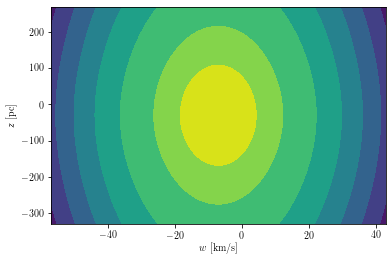

In [18]:
nw = 200
nz = 10000
w = np.linspace(w0-50, w0+50, nw)
z = np.linspace(-zsun-300, -zsun+300, nz)
dz = 0.2
W, Z = np.meshgrid(w, z)
w2 = np.ravel(W)
z2 = np.ravel(Z)
pos = np.vstack([z2, w2]).T

pot = Model.DM.fzw(pos, theta, dz)

pot = pot.reshape((nz, nw))
pot.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.contourf(W, Z, np.log(pot), cmap="viridis")
ax.set_xlabel(r'$w$ [km/s]')
ax.set_ylabel(r'$z$ [pc]')
plt.show()

In [9]:
# phi = Model.DM.potential(z, theta, dz)

# mask = np.abs(z+zsun) < 10
# p = np.polyfit(z[mask], phi[mask], 2)

# plt.plot(z, phi)
# plt.plot(z, np.polyval(p, z), ls="--")
# plt.show()

# p, alpha**2

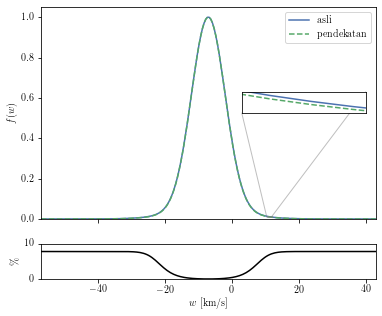

In [19]:
mask = np.abs(z+zsun) < 50
Fw = np.trapz(pot[mask, :], z[mask], axis=0)
Fw = Fw/Fw.max()
fmod = Model.DM.fw(w, theta)
fmod = fmod/fmod.max()
fig, axes = plt.subplots(2, 1, figsize=(6, 5), gridspec_kw={'height_ratios': [6, 1]}, sharex=True)
axin = axes[0].inset_axes([0.6, 0.5, 0.37, 0.1])
axin.set_xlim(10.5, 12)
axin.set_ylim(0.008, 0.013)
# axin.set_yscale('log')
axin.set_xticks([])
axin.set_yticks([])
axin.plot(w, Fw)
axin.plot(w, fmod, ls='--')

axes[0].indicate_inset_zoom(axin)
axes[0].plot(w, Fw, label='asli')
axes[0].plot(w, fmod, ls='--', label='pendekatan')
axes[0].set_ylabel(r'$f(w)$')
axes[0].set_ylim(0)
axes[0].set_xlim(w.min(), w.max())
axes[0].legend()
axes[1].plot(w, (Fw-fmod)/Fw*100, c='k')
axes[1].set_xlabel(r'$w$ [km/s]')
axes[1].set_ylabel(r'$\%$')
axes[1].set_ylim(0, 10)
axes[1].set_xlim(w.min(), w.max())
fig.savefig(join("img", "f0.pdf"), dpi=70)
plt.show()

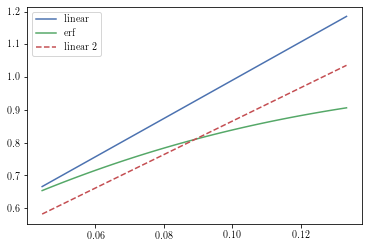

In [20]:
from scipy.special import erf

# rho_min = rhob.sum()*0.50
# rho_max = rhob.sum()*1.70
rho_min = rhob.sum()*0.5
rho_max = rhob.sum()*1.5
alpha_min = np.sqrt(0.5*4*np.pi*G*(rho_min - R))
alpha_max = np.sqrt(0.5*4*np.pi*G*(rho_max - R))

alphas = np.linspace(alpha_min, alpha_max, 100)
e = erf(alphas*100/sigmaw1)
x = alphas*100/sigmaw1
ratio = np.mean(e/x)
rho = np.linspace(rho_min, rho_max, 100)

plt.plot(rho, x, label='linear')
plt.plot(rho, erf(x), label='erf')
plt.plot(rho, x*ratio, label='linear 2', ls="--")
# plt.ylim(0)
plt.legend()


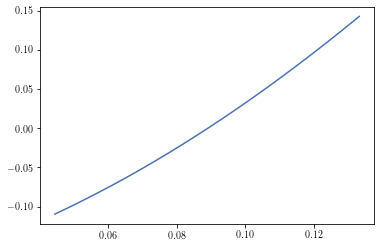

In [21]:
plt.plot(rho, (x*ratio-e)/e)

# Prediksi

In [22]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101

rhob = np.array(df_baryon["rho"].to_numpy())  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
rhoDM = 0.016
sigmaDD = 7
hDD = 30
log_nu0 = 0
zsun = 30
R = 3.4E-3
w0 = -7
sigmaw1 = 5
sigmaw2 = 10
log_sigmaw = np.log(sigmaw1)
q_sigmaw = sigmaw1/sigmaw2
a1 = 1
a2 = 0.1
a = a1 + a2
log_a = np.log(a)
q_a = a1/a

theta_dm = concat(sigmaz, rhob, rhoDM, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)
theta_dddm = concat(sigmaz, rhob, rhoDM, sigmaDD, hDD, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)
theta_no = concat(sigmaz, rhob, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)

# integration limits
z_start = 0
z_end = 400
theta.shape

(33,)

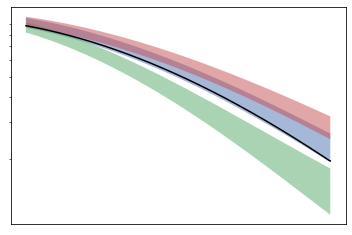

In [23]:
z = np.linspace(0, 100, 500)
dz = z[1] - z[0]
nu_dm = Model.DM.fz(z, theta_dm, dz=dz)
nu_dddm = Model.DDDM.fz(z, theta_dddm, dz=dz)
nu_no = Model.NO.fz(z, theta_no, dz=dz)

# plt.plot(z, nu_dm+0.05-(z/1000)**2)
plt.plot(z, nu_dm-0.03, c='k')
# plt.plot(z, nu_dm-0.05+(z/750)**2)
# plt.plot(z, nu_dddm)
plt.fill_between(z, nu_dm+0.05-(z/1000)**2, nu_dm-0.05+(z/750)**2, alpha=0.5)
plt.fill_between(z, nu_dddm+0.05-(z/1000)**2, nu_dddm-0.05+(z/750)**2, alpha=0.5)
plt.fill_between(z, nu_no+0.05-(z/1000)**2, nu_no-0.05+(z/750)**2, alpha=0.5)
# plt.plot(z, nu_dddm+0.05-(z/1000)**2)
# plt.plot(z, nu_dddm)
# plt.plot(z, nu_dddm-0.05+(z/750)**2)
# plt.plot(z, nu_no)
plt.yscale('log')
plt.yticks([])
plt.xticks([])
plt.savefig(join('img', 'prediksi.png'), dpi=300)
plt.show()
